In [72]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import module_joaquin as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
df = pd.read_excel("data/USD_SOFR.xlsx", index_col=0, header=0)
df.dropna(inplace=True)
df.head()

,USD1y1y,USD2y1y,USD3y1y,USD4y1y,USD5y2y,USD7y3y,USD10y5y,USD15y5y,USD20y5y,USD25y5y
Trade Day,,,,,,,,,,
2011-09-27,0.177201,0.613752,1.364864,2.038994,2.655216,3.057123,3.349836,3.160193,3.063415,2.944442
2011-09-28,0.181141,0.602388,1.394476,2.021346,2.639105,3.067483,3.334938,3.143473,3.047186,2.956431
2011-09-29,0.192427,0.678039,1.405417,2.085105,2.652564,3.058120,3.321548,3.118247,3.020588,2.954893
2011-09-30,0.193416,0.635942,1.323026,1.946972,2.605848,2.920937,3.154124,2.940650,2.832992,2.759629
2011-10-03,0.179286,0.588597,1.215862,1.801201,2.345519,2.704160,2.933541,2.733042,2.631103,2.530194


In [74]:
train_df = df[df.index < "2020-01-01"] * 0.01
test_df = df[~(df.index < "2020-01-01")] * 0.01

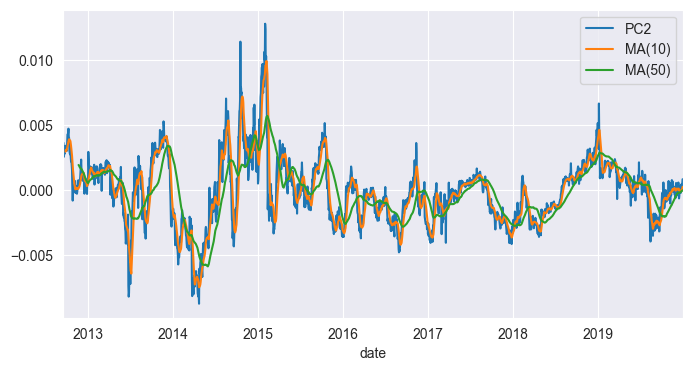

In [88]:
train_scores, train_pca = mod.rolling_pca(train_df,
                                          corr_window_size=252,
                                          vol_window_size=60,
                                          recalibration_period=30)

short_ma_window = 10
long_ma_window = 50
short_ma = train_scores["PC2"].rolling(short_ma_window).mean()
long_ma = train_scores["PC2"].rolling(long_ma_window).mean()

plt.figure(figsize=(8, 4))
train_scores["PC2"].plot(label="PC2")
short_ma.plot(label=f"MA({short_ma_window})")
long_ma.plot(label=f"MA({long_ma_window})")
plt.legend()
plt.show()


In [76]:
from scipy.optimize import brute

def neg_ema_strat_sharpe(X):
    short, long, threshold = X
    # enforce integer EMAs & simple constraints
    short = int(round(short))
    long  = int(round(long))
    threshold = float(threshold)

    if short < 1 or long <= short:
        return 1e6
    sharpe = mod.ema_strat_sharpe(train_scores, train_pca, train_df, short, long, threshold)
    # If your ema_strat_sharpe returns -inf on bad configs, penalize
    if not np.isfinite(sharpe):
        return 1e6

    return -sharpe   # because we want to MAXIMIZE the Sharpe

# slice(start, stop, step) — stop is INCLUDED by brute
rranges = (
    slice(5, 31, 5),        # short: 5,10,15,20,25,30
    slice(50, 201, 10),     # long: 50,60,...,200
    slice(0.0, 0.01000001, 5e-5),  # threshold: pace 0.5 bp
)

best_x, best_f, grid_vals, grid_sharpes = brute(
                                    neg_ema_strat_sharpe,
                                    rranges,
                                    full_output=True,
                                    finish=None,  # IMPORTANT: don't run a local optimizer afterwards
                                )

best_short     = int(round(best_x[0]))
best_long      = int(round(best_x[1]))
best_threshold = float(best_x[2])
best_sharpe    = -best_f

print("Best params via brute:")
print("  short     =", best_short)
print("  long      =", best_long)
print("  threshold =", best_threshold)
print("  Sharpe    =", best_sharpe)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value enc

Best params via brute:
  short     = 10
  long      = 50
  threshold = 0.0036000000000000003
  Sharpe    = 0.2755694607969782


<Axes: xlabel='date'>

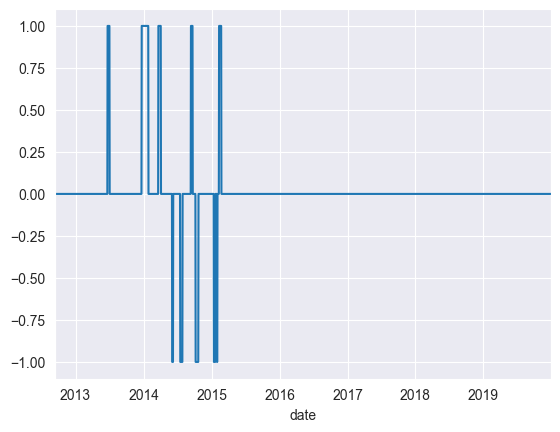

In [87]:
trades, df2 = mod.ema_strat(train_scores, train_pca, train_df, short=10, long=50, threshold=0.0030)
df2["position"].plot()

In [93]:
df_trades = pd.DataFrame(trades)
df_trades.drop(columns=["pc_loading", "portfolio","mtm"], inplace=True)
df_trades

,entry_date,exit_date,position,days,pnl,vol
0,2013-06-21,2013-07-03,1,9,0.004234,0.008356
1,2013-12-23,2014-01-28,1,27,-0.007453,0.003645
2,2014-03-21,2014-04-04,1,11,0.014335,0.006502
3,2014-06-04,2014-06-10,-1,5,-0.007909,0.002226
4,2014-07-17,2014-07-30,-1,10,0.003734,0.001112
5,2014-09-12,2014-09-23,1,8,-0.000084,0.001154
6,2014-10-08,2014-10-23,-1,12,-0.000206,0.002230
7,2015-01-14,2015-01-22,-1,7,-0.001976,0.001066
8,2015-01-30,2015-02-03,-1,3,-0.000680,0.000349
9,2015-02-11,2015-02-24,1,10,0.001798,0.000817


In [86]:
sharpe = mod.ema_strat_sharpe(train_scores, train_pca, train_df, short=10, long=50, threshold=0.0030)
sharpe

np.float64(0.020896864497368047)

In [78]:
date = "2013-06-21"
pca_lookup = mod.build_pca_lookup(train_pca)
loading = pca_lookup(date)
portfolio = mod.dv01_neutral_portfolio(loading[1, :], train_df.loc[date])
print(loading[1, :])
print(portfolio)

[-0.51326558 -0.35487875 -0.43611226 -0.2910127  -0.02708776  0.16916033
  0.27092857  0.27632877  0.27115062  0.28828065]
[-1.71968505 -1.91213617 -2.49319089 -2.33879879 -1.33811657 -0.10861002
  1.18163836  2.14588027  2.83070059  3.75231828]


In [79]:
mod.annuity_vector(train_df.loc["2019-12-31"])

array([ 0.98621095,  1.95812782,  2.91526396,  3.85689949,  4.78225068,
        6.58114339,  9.14929484, 13.10240707, 16.69052627, 19.96031382])